In [1]:
import pandas as pd

# normalize 할때 사용이 되어집니다
def minmax_norm(df):
    return (df - df.min()) / (df.max() - df.min())

# kmeans 클러스터링을 사용합니다
# input으로는 dataframe, cluster 개수, cluster epoch 횟수를 받습니다
# 출력으로는 cluster 결과가 반영된 dataframe, clustering 지표중 하나인 실루엣 점수가 출력 됩니다
def kmeans(df, n_clusters = 4, epo = 300):
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score
    points = df.values
    kmeans = KMeans(n_clusters, max_iter = epo).fit(points)
    df['cluster'] = kmeans.labels_
    score = silhouette_score(points, kmeans.labels_)
    return df, score

# t_sne 방법을 통해서 클러스터 결과를 시각화 해주는 함수입니다
# 입력으로는 dataframe, cluster 개수를 받습니다 (클러스터링에서 클러스터 갯수 입력한 그대로 입력하면 됩니다)
# 반환되는 값은 따로 없으며 t-sne 결과가 자동으로 출력이 되게 됩니다 (실행시간이 오래걸릴 수 가 있습니다)
def t_sne(df, n_clusters):
    import matplotlib.pyplot as plt
    from sklearn.manifold import TSNE
    model = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    transformed = model.fit_transform(df.values)
    xs = transformed[:,0]
    ys = transformed[:,1]
    
    import seaborn as sns
    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x=xs, y=ys,
        hue=df['cluster'],
        palette=sns.color_palette("hls", n_clusters),
        data=df,
        legend="full",
        alpha=0.3
    )

# 각 클러스터 마다 각 장학금을 수혜받은 학생수와 수혜받은 비율을 보여줍니다
# 이를 통해 각 클러스터마다 어떤 장학금을 받을 확률이 높은지 가늠해볼 수 있습니다
# input은 클러스터 결과가 반영된 dataframe, data 초기값, 클러스터 이름 입니다
# 여기서 data 초기값은 기존의 장학금코드와 학번 정보를 사용하기 위해서 사용하는 것
# 우리가 알고 싶은 클러스터의 이름을 쓰면 됩니다 (숫자)
# 최종적으로 특정 클러스터에 장학금별로 몇명의 학생이 수혜를 받았고 전체 학생대비 비율은 어떠한지를 출력하고
# 이 결과들을 dataframe으로 반환합니다
def scholar_user(df_cluster, data, cluster_name):
    # 클러스터 결과가 반영된 dataframe과 data에서 가져온 장학금코드, 학번 정보를 가져오고 합칩니다
    df_concat = pd.concat([df_cluster, data['장학금코드'], data['학번']], axis = 1)
    # 우리가 알고 싶은 클러스터의 이름과 조건이 일치한 데이터만 다루게 됩니다
    df_cluster = df_concat[df_concat['cluster'] == cluster_name]
    
    user_all = 0
    user_list = []
    dict = {}
    # 장학금을 기준으로 아래 명령들이 실행되게 됩니다
    for scholar in set(df_cluster['장학금코드']):
        # 장학금 별로 학생이 얼마나 있는지 파악합니다
        cluster_scholar = df_cluster[df_cluster['장학금코드'] == scholar]
        user_list += list(cluster_scholar['학번'].values)
        # 동일한 장학금을 동일한 장학생이 여러 학기에 걸쳐서 받을 수 있기 때문에 set 함수를 썼습니다
        user_n = len(set(cluster_scholar['학번']))
        # 아래는 장학금 별로 수혜자가 별로 없는 장학금을 걸러내기 위해서 사용할 수 있습니다
        # 현재는 user_n이 1보다 작은경우에만 pass 이므로 모든 장학금들의 결과가 다 반영되겠지만
        # 이부분을 수정함으로서 수혜자 수가 너무 작은 장학금들을 걸러낼 수 있습니다
        if user_n < 1:
            pass
        else:
            user_all += user_n

            # 해당하는 장학금을 받은 전체 학생중에서 현재 클러스터에서 수혜받은 학생의 비율이 얼마나 되는지 파악합니다
            user_n_all_cl = len(set(data[data['장학금코드'] == scholar]['학번']))
            user_percent = user_n/user_n_all_cl*100

            dict[f'{scholar}'] = [user_n, user_percent]
            print(f'scholar_code : {scholar} , user_n : {user_n}, user_percent : {user_percent}')
        
    print(f'총 장학금 수혜 받은 학생 수 : {user_all}')
    print(f'총 장학금 수혜 받은 학생 수 (중복제거) : {len(set(user_list))}')
    
    # 위의 정보를 바탕으로 클러스터 내에서 장학금 별로 수혜받은 학생수와 수혜 비율을 가지고 dataframe을 만들어 줍니다 
    df = pd.DataFrame.from_dict(dict, orient='index', columns = ['user_n', 'user_percent'])
    
    # 정렬합니다
    df_sort = df.sort_values(by='user_percent', axis=0, ascending=False)
    df_sort = df_sort.sort_values(by='user_n', axis=0, ascending=False)
    
    return df_sort

# 아래 함수는 기존 엑셀 데이터에서 전처리 작업해 준것을 한데 모은 것입니다
def make_df(data):
    df_drop = data.drop( ['구분', '년도', '학기', '학번', '장학금코드', '대학원코드', 
                          '수업료', '입학금', '등록금', '기타금액', '지급구분(사전1 사후2)', 
                          '입학년도', '입학학기', '직전학기', '학적상태', '지도교수'], axis = 1)
    df_nan = df_drop.fillna(0)
    pd_depart = pd.get_dummies(df_nan['학과코드'])
    pd_regist = pd.get_dummies(df_nan['학적상태코드'])
    df_drop2 = df_nan.drop(['학과코드', '학적상태코드'], axis = 1) 
    df_concat = pd.concat([df_drop2, pd_depart, pd_regist], axis = 1)
    df_norm = minmax_norm(df_concat)
    
    return df_norm

In [2]:
data = pd.read_excel('대학원_장학금지급_복사본.xlsx')

In [3]:
df_norm = make_df(data)

In [4]:
df_norm

,등록학기,직전학기성적,직전학기누계성적,311,312,313,314,316,317,318,...,6767,6877,0.0,101.0,201.0,202.0,302.0,303.0,304.0,401.0
0,0.115385,0.973333,0.973333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.038462,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.576923,0.000000,0.880000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.500000,0.000000,0.926667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.500000,0.000000,0.842222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66682,0.000000,0.917778,0.917778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
66683,0.000000,1.000000,0.982222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
66684,0.000000,0.944444,0.944444,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
66685,0.153846,0.944444,0.986667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
df_test, score = kmeans(df_norm, 50, 300)

In [5]:
df_test, score = kmeans(df_norm, 400, 300)

In [6]:
df_test

,등록학기,직전학기성적,직전학기누계성적,311,312,313,314,316,317,318,...,6877,0.0,101.0,201.0,202.0,302.0,303.0,304.0,401.0,cluster
0,0.115385,0.973333,0.973333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,64
1,0.038462,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,175
2,0.576923,0.000000,0.880000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,83
3,0.500000,0.000000,0.926667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,83
4,0.500000,0.000000,0.842222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66682,0.000000,0.917778,0.917778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,59
66683,0.000000,1.000000,0.982222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,120
66684,0.000000,0.944444,0.944444,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,120
66685,0.153846,0.944444,0.986667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,11


In [7]:
df_test.to_csv("cluster400.csv") 

In [8]:
score

0.7968171093832527

In [11]:
import numpy as np
np.save('cluster/400cluster/cluster400_score.npy', score)

In [43]:
df_norm.to_csv("df_norm.csv")

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 66687 samples in 0.010s...
[t-SNE] Computed neighbors for 66687 samples in 72.751s...
[t-SNE] Computed conditional probabilities for sample 1000 / 66687
[t-SNE] Computed conditional probabilities for sample 2000 / 66687
[t-SNE] Computed conditional probabilities for sample 3000 / 66687
[t-SNE] Computed conditional probabilities for sample 4000 / 66687
[t-SNE] Computed conditional probabilities for sample 5000 / 66687
[t-SNE] Computed conditional probabilities for sample 6000 / 66687
[t-SNE] Computed conditional probabilities for sample 7000 / 66687
[t-SNE] Computed conditional probabilities for sample 8000 / 66687
[t-SNE] Computed conditional probabilities for sample 9000 / 66687
[t-SNE] Computed conditional probabilities for sample 10000 / 66687
[t-SNE] Computed conditional probabilities for sample 11000 / 66687
[t-SNE] Computed conditional probabilities for sample 12000 / 66687
[t-SNE] Computed conditional probabilities for s

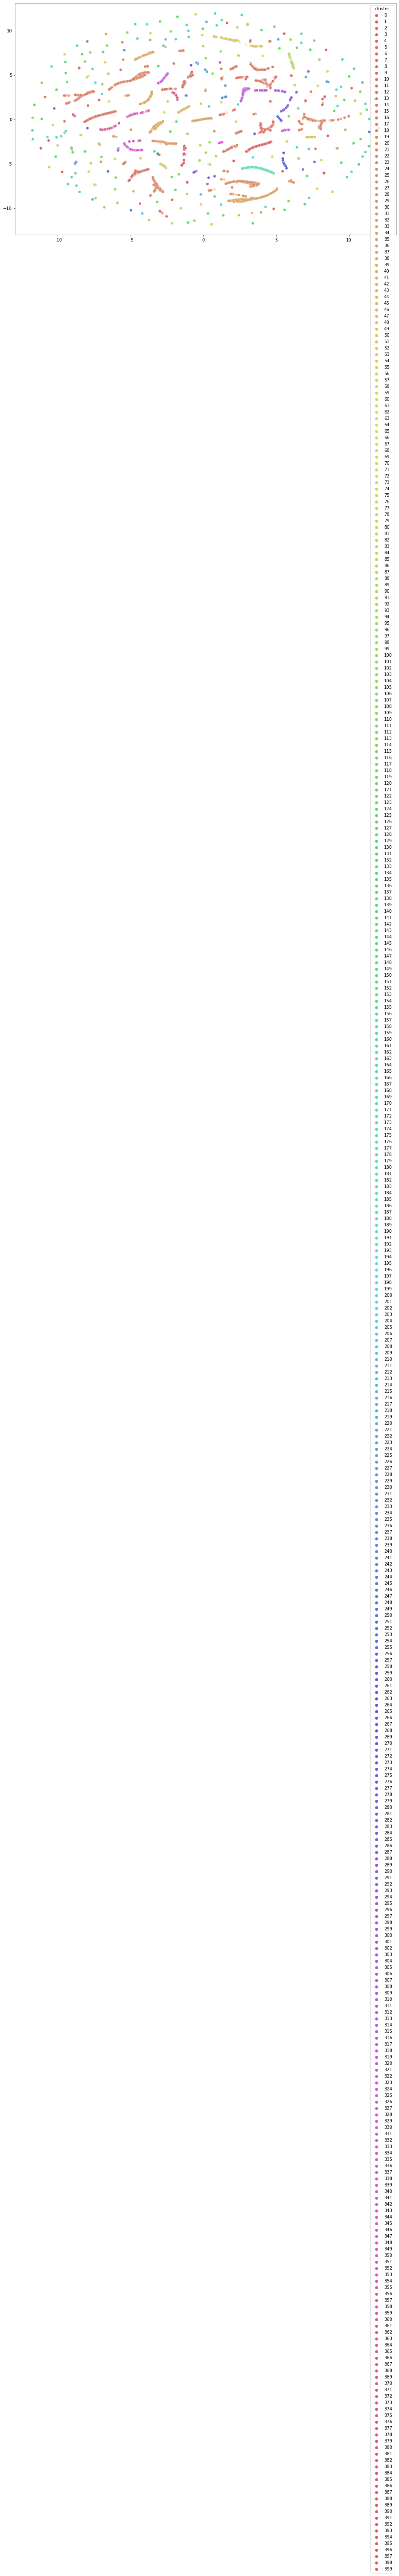

In [12]:
t_sne(df_test, 400)

In [13]:
df_test_100, score_100 = kmeans(df_norm, 100, 300)

In [14]:
df_test_100.to_csv("cluster100.csv") 

In [15]:
np.save('score_100.npy', score_100)

In [4]:
df_test, score = kmeans(df_norm, 8, 100000)
print(score)

Initialization complete
Iteration 0, inertia 119139.81420586107
Iteration 1, inertia 64920.21981395804
Iteration 2, inertia 61501.68797464238
Iteration 3, inertia 61240.24506752026
Iteration 4, inertia 61010.238897622155
Iteration 5, inertia 61002.69982061116
Iteration 6, inertia 60927.67411374589
Iteration 7, inertia 60856.69188944329
Iteration 8, inertia 60854.95914511819
Iteration 9, inertia 60854.7099534185
Iteration 10, inertia 60854.65021243811
Iteration 11, inertia 60854.52048781995
Converged at iteration 11: center shift 7.843494264242998e-08 within tolerance 1.125131380502537e-06.
Initialization complete
Iteration 0, inertia 118042.11457965289
Iteration 1, inertia 65385.11789278912
Iteration 2, inertia 62026.24815629352
Iteration 3, inertia 61932.86124714932
Iteration 4, inertia 61893.68545431905
Iteration 5, inertia 61794.84716336781
Iteration 6, inertia 61665.31982949494
Iteration 7, inertia 61631.50280002361
Iteration 8, inertia 61631.36659269661
Converged at iteration 8: c

In [8]:
for i in range(2, 10 + 1):
    df_test, score = kmeans(df_norm, i, 300)
    print(f'cluster 갯수 : {i}개, 실루엣  : {score}')

cluster 갯수 : 2개, 실루엣  : 0.5487569030669613
cluster 갯수 : 3개, 실루엣  : 0.24202554504179966
cluster 갯수 : 4개, 실루엣  : 0.17448379029730837
cluster 갯수 : 5개, 실루엣  : 0.3582497355359132
cluster 갯수 : 6개, 실루엣  : 0.18923666342833775
cluster 갯수 : 7개, 실루엣  : 0.40423536825604106
cluster 갯수 : 8개, 실루엣  : 0.2411928506031047
cluster 갯수 : 9개, 실루엣  : 0.2734955618672132
cluster 갯수 : 10개, 실루엣  : 0.3287588992465102


In [9]:
for i in range(11, 20 + 1):
    df_test, score = kmeans(df_norm, i, 300)
    print(f'cluster 갯수 : {i}개, 실루엣  : {score}')

cluster 갯수 : 11개, 실루엣  : 0.3683812850169669
cluster 갯수 : 12개, 실루엣  : 0.31118074237715315
cluster 갯수 : 13개, 실루엣  : 0.2940318611501666
cluster 갯수 : 14개, 실루엣  : 0.3441306881685527
cluster 갯수 : 15개, 실루엣  : 0.34230338633542107
cluster 갯수 : 16개, 실루엣  : 0.36592634278227687
cluster 갯수 : 17개, 실루엣  : 0.3956907569397556
cluster 갯수 : 18개, 실루엣  : 0.4002049157458646
cluster 갯수 : 19개, 실루엣  : 0.36470151761312064
cluster 갯수 : 20개, 실루엣  : 0.43913855712301303


In [ ]:
for i in range(70, 400 + 1):
    df_test, score = kmeans(df_norm, i, 300)
    print(f'cluster 갯수. : {i}개, 실루엣  : {score}')

In [14]:
df_test, score = kmeans(df_norm, 400, 300)

In [45]:
df_test

,등록학기,직전학기성적,직전학기누계성적,311,312,313,314,316,317,318,...,6877,0.0,101.0,201.0,202.0,302.0,303.0,304.0,401.0,cluster
0,0.115385,0.973333,0.973333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,37
1,0.038462,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,32
2,0.576923,0.000000,0.880000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,66
3,0.500000,0.000000,0.926667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,66
4,0.500000,0.000000,0.842222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66682,0.000000,0.917778,0.917778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,69
66683,0.000000,1.000000,0.982222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,57
66684,0.000000,0.944444,0.944444,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,57
66685,0.153846,0.944444,0.986667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,47


In [44]:
df_test.to_csv("cluster400.csv")

In [15]:
score

0.9258293310409199

In [46]:
import numpy as np

In [48]:
score

0.5806817458092507

In [50]:
np.save('cluster/70cluster/cluster70_score.npy', score)

In [51]:
score2 = 0.9258293310409199

In [52]:
score2

0.9258293310409199

In [54]:
np.save('cluster/400cluster/cluster400_score.npy', score2)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 66687 samples in 0.011s...
[t-SNE] Computed neighbors for 66687 samples in 126.260s...
[t-SNE] Computed conditional probabilities for sample 1000 / 66687
[t-SNE] Computed conditional probabilities for sample 2000 / 66687
[t-SNE] Computed conditional probabilities for sample 3000 / 66687
[t-SNE] Computed conditional probabilities for sample 4000 / 66687
[t-SNE] Computed conditional probabilities for sample 5000 / 66687
[t-SNE] Computed conditional probabilities for sample 6000 / 66687
[t-SNE] Computed conditional probabilities for sample 7000 / 66687
[t-SNE] Computed conditional probabilities for sample 8000 / 66687
[t-SNE] Computed conditional probabilities for sample 9000 / 66687
[t-SNE] Computed conditional probabilities for sample 10000 / 66687
[t-SNE] Computed conditional probabilities for sample 11000 / 66687
[t-SNE] Computed conditional probabilities for sample 12000 / 66687
[t-SNE] Computed conditional probabilities for 

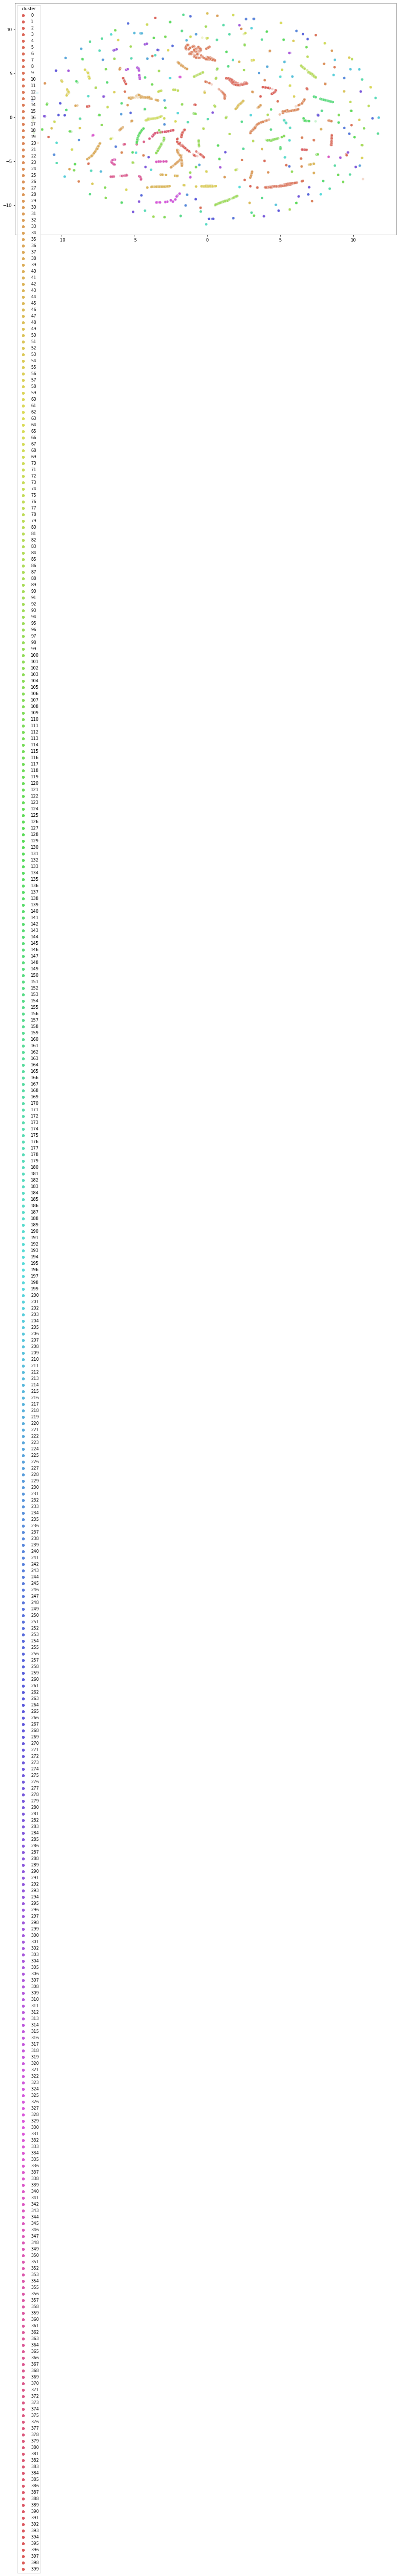

In [17]:
t_sne(df_test, 400)

In [37]:
df_test, score = kmeans(df_norm, 70, 300)

In [55]:
df_test

,등록학기,직전학기성적,직전학기누계성적,311,312,313,314,316,317,318,...,6877,0.0,101.0,201.0,202.0,302.0,303.0,304.0,401.0,cluster
0,0.115385,0.973333,0.973333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,37
1,0.038462,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,32
2,0.576923,0.000000,0.880000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,66
3,0.500000,0.000000,0.926667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,66
4,0.500000,0.000000,0.842222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66682,0.000000,0.917778,0.917778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,69
66683,0.000000,1.000000,0.982222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,57
66684,0.000000,0.944444,0.944444,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,57
66685,0.153846,0.944444,0.986667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,47


In [56]:
df_test.to_csv("cluster/70cluster/cluster70.csv")

In [38]:
score

0.5806817458092507

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 66687 samples in 0.019s...
[t-SNE] Computed neighbors for 66687 samples in 75.243s...
[t-SNE] Computed conditional probabilities for sample 1000 / 66687
[t-SNE] Computed conditional probabilities for sample 2000 / 66687
[t-SNE] Computed conditional probabilities for sample 3000 / 66687
[t-SNE] Computed conditional probabilities for sample 4000 / 66687
[t-SNE] Computed conditional probabilities for sample 5000 / 66687
[t-SNE] Computed conditional probabilities for sample 6000 / 66687
[t-SNE] Computed conditional probabilities for sample 7000 / 66687
[t-SNE] Computed conditional probabilities for sample 8000 / 66687
[t-SNE] Computed conditional probabilities for sample 9000 / 66687
[t-SNE] Computed conditional probabilities for sample 10000 / 66687
[t-SNE] Computed conditional probabilities for sample 11000 / 66687
[t-SNE] Computed conditional probabilities for sample 12000 / 66687
[t-SNE] Computed conditional probabilities for s

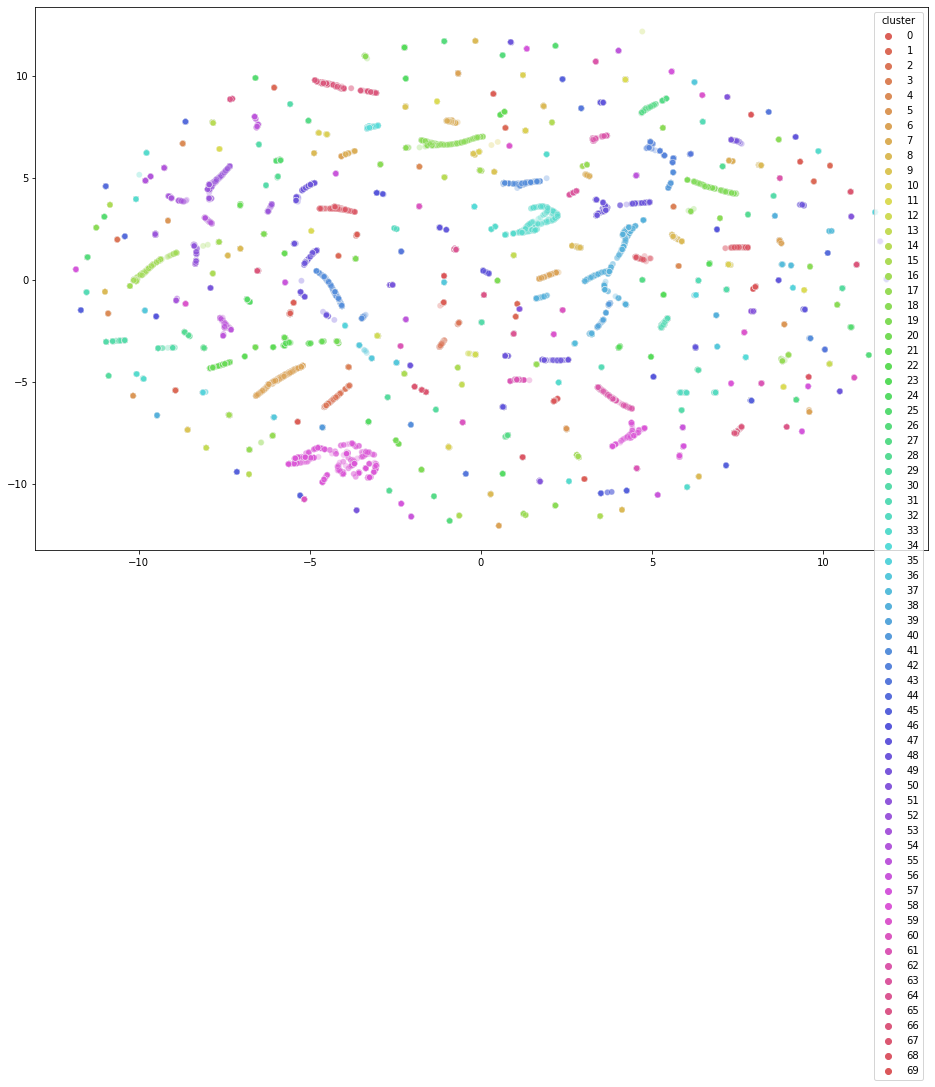

In [39]:
t_sne(df_test, 70)

In [40]:
for i in range(0, 70):
    df_fin = scholar_user(df_test, data, i)
    print(f'{i}클러스터링 결과입니다')
    print('여기까지 --------------')

scholar_code : 12855 , user_n : 70, user_percent : 2.0272227048942946
scholar_code : 12856 , user_n : 14, user_percent : 3.004291845493562
scholar_code : 12863 , user_n : 17, user_percent : 0.7910656119125176
scholar_code : 12864 , user_n : 14, user_percent : 3.0434782608695654
scholar_code : 12865 , user_n : 11, user_percent : 1.3597033374536465
scholar_code : 22630 , user_n : 252, user_percent : 6.892778993435448
scholar_code : 11948 , user_n : 11, user_percent : 4.365079365079365
scholar_code : 13492 , user_n : 15, user_percent : 10.56338028169014
scholar_code : 23751 , user_n : 55, user_percent : 2.718734552644587
scholar_code : 14538 , user_n : 13, user_percent : 1.0236220472440944
scholar_code : 13053 , user_n : 22, user_percent : 11.282051282051283
scholar_code : 13570 , user_n : 22, user_percent : 6.790123456790123
scholar_code : 14115 , user_n : 11, user_percent : 9.734513274336283
scholar_code : 13126 , user_n : 112, user_percent : 7.325049051667756
scholar_code : 11206 , use

scholar_code : 12857 , user_n : 21, user_percent : 2.459016393442623
scholar_code : 12863 , user_n : 33, user_percent : 1.5355979525360632
scholar_code : 13905 , user_n : 23, user_percent : 5.15695067264574
scholar_code : 22630 , user_n : 30, user_percent : 0.8205689277899343
scholar_code : 23723 , user_n : 19, user_percent : 63.33333333333333
scholar_code : 23751 , user_n : 13, user_percent : 0.6426099851705388
scholar_code : 14538 , user_n : 34, user_percent : 2.677165354330709
scholar_code : 14605 , user_n : 14, user_percent : 73.68421052631578
scholar_code : 13126 , user_n : 17, user_percent : 1.1118378024852846
scholar_code : 11206 , user_n : 16, user_percent : 0.7064017660044151
scholar_code : 22484 , user_n : 11, user_percent : 3.873239436619718
총 장학금 수혜 받은 학생 수 : 298
총 장학금 수혜 받은 학생 수 (중복제거) : 305
11클러스터링 결과입니다
여기까지 --------------
scholar_code : 12855 , user_n : 42, user_percent : 1.2163336229365769
scholar_code : 12857 , user_n : 13, user_percent : 1.5222482435597189
scholar_co

scholar_code : 12857 , user_n : 26, user_percent : 3.0444964871194378
scholar_code : 12863 , user_n : 53, user_percent : 2.466263378315496
scholar_code : 12865 , user_n : 10, user_percent : 1.2360939431396787
scholar_code : 22630 , user_n : 116, user_percent : 3.1728665207877462
scholar_code : 13956 , user_n : 12, user_percent : 1.643835616438356
scholar_code : 14521 , user_n : 11, user_percent : 28.947368421052634
scholar_code : 23751 , user_n : 34, user_percent : 1.680672268907563
scholar_code : 14538 , user_n : 34, user_percent : 2.677165354330709
scholar_code : 14539 , user_n : 17, user_percent : 1.347068145800317
scholar_code : 11206 , user_n : 53, user_percent : 2.3399558498896247
총 장학금 수혜 받은 학생 수 : 498
총 장학금 수혜 받은 학생 수 (중복제거) : 376
23클러스터링 결과입니다
여기까지 --------------
scholar_code : 12855 , user_n : 77, user_percent : 2.229944975383724
scholar_code : 12856 , user_n : 19, user_percent : 4.07725321888412
scholar_code : 12857 , user_n : 15, user_percent : 1.756440281030445
scholar_cod

scholar_code : 12855 , user_n : 37, user_percent : 1.071532001158413
scholar_code : 12863 , user_n : 20, user_percent : 0.9306654257794323
scholar_code : 13905 , user_n : 23, user_percent : 5.15695067264574
scholar_code : 13906 , user_n : 19, user_percent : 8.225108225108226
scholar_code : 14424 , user_n : 14, user_percent : 87.5
scholar_code : 22630 , user_n : 25, user_percent : 0.6838074398249453
scholar_code : 13956 , user_n : 22, user_percent : 3.0136986301369864
scholar_code : 23751 , user_n : 19, user_percent : 0.9391992090954029
scholar_code : 14538 , user_n : 10, user_percent : 0.7874015748031495
scholar_code : 13570 , user_n : 22, user_percent : 6.790123456790123
scholar_code : 10030 , user_n : 25, user_percent : 19.083969465648856
scholar_code : 13126 , user_n : 24, user_percent : 1.5696533682145193
scholar_code : 13663 , user_n : 10, user_percent : 7.936507936507936
scholar_code : 11206 , user_n : 205, user_percent : 9.050772626931568
scholar_code : 22484 , user_n : 12, user

scholar_code : 12855 , user_n : 37, user_percent : 1.071532001158413
scholar_code : 13126 , user_n : 41, user_percent : 2.6814911706998035
scholar_code : 23751 , user_n : 13, user_percent : 0.6426099851705388
scholar_code : 22630 , user_n : 51, user_percent : 1.3949671772428884
총 장학금 수혜 받은 학생 수 : 154
총 장학금 수혜 받은 학생 수 (중복제거) : 204
42클러스터링 결과입니다
여기까지 --------------
scholar_code : 12855 , user_n : 81, user_percent : 2.3457862728062553
scholar_code : 12856 , user_n : 26, user_percent : 5.579399141630901
scholar_code : 12863 , user_n : 39, user_percent : 1.8147975802698928
scholar_code : 12864 , user_n : 26, user_percent : 5.6521739130434785
scholar_code : 13912 , user_n : 10, user_percent : 22.22222222222222
scholar_code : 11352 , user_n : 17, user_percent : 13.821138211382115
scholar_code : 22630 , user_n : 150, user_percent : 4.102844638949672
scholar_code : 23676 , user_n : 10, user_percent : 7.8125
scholar_code : 23751 , user_n : 56, user_percent : 2.768166089965398
scholar_code : 1453

50클러스터링 결과입니다
여기까지 --------------
scholar_code : 13699 , user_n : 11, user_percent : 12.359550561797752
scholar_code : 13126 , user_n : 58, user_percent : 3.793328973185088
scholar_code : 14538 , user_n : 13, user_percent : 1.0236220472440944
총 장학금 수혜 받은 학생 수 : 82
총 장학금 수혜 받은 학생 수 (중복제거) : 138
51클러스터링 결과입니다
여기까지 --------------
scholar_code : 13570 , user_n : 32, user_percent : 9.876543209876543
scholar_code : 13956 , user_n : 14, user_percent : 1.9178082191780823
scholar_code : 11948 , user_n : 10, user_percent : 3.968253968253968
scholar_code : 12855 , user_n : 80, user_percent : 2.3168259484506226
scholar_code : 12856 , user_n : 22, user_percent : 4.721030042918455
scholar_code : 12863 , user_n : 24, user_percent : 1.116798510935319
scholar_code : 12864 , user_n : 15, user_percent : 3.260869565217391
scholar_code : 12865 , user_n : 10, user_percent : 1.2360939431396787
scholar_code : 13126 , user_n : 18, user_percent : 1.1772400261608895
scholar_code : 11206 , user_n : 34, user_perce

scholar_code : 13126 , user_n : 16, user_percent : 1.0464355788096795
scholar_code : 14538 , user_n : 12, user_percent : 0.9448818897637795
scholar_code : 22630 , user_n : 18, user_percent : 0.4923413566739606
총 장학금 수혜 받은 학생 수 : 61
총 장학금 수혜 받은 학생 수 (중복제거) : 87
63클러스터링 결과입니다
여기까지 --------------
scholar_code : 12816 , user_n : 15, user_percent : 6.172839506172839
scholar_code : 12855 , user_n : 100, user_percent : 2.8960324355632783
scholar_code : 12857 , user_n : 20, user_percent : 2.3419203747072603
scholar_code : 12863 , user_n : 95, user_percent : 4.420660772452304
scholar_code : 12864 , user_n : 14, user_percent : 3.0434782608695654
scholar_code : 12865 , user_n : 30, user_percent : 3.7082818294190356
scholar_code : 13905 , user_n : 30, user_percent : 6.726457399103139
scholar_code : 22630 , user_n : 26, user_percent : 0.7111597374179431
scholar_code : 13430 , user_n : 32, user_percent : 26.01626016260163
scholar_code : 23751 , user_n : 17, user_percent : 0.8403361344537815
scholar_

In [28]:
df_fin = scholar_user(df_test, data, 0)

scholar_code : 22528 , user_n : 6, user_percent : 5.128205128205128
scholar_code : 22529 , user_n : 6, user_percent : 5.084745762711865
scholar_code : 22530 , user_n : 6, user_percent : 5.084745762711865
scholar_code : 22531 , user_n : 20, user_percent : 12.987012987012985
scholar_code : 22532 , user_n : 13, user_percent : 10.833333333333334
scholar_code : 22533 , user_n : 13, user_percent : 10.92436974789916
scholar_code : 22534 , user_n : 13, user_percent : 10.92436974789916
scholar_code : 22535 , user_n : 13, user_percent : 10.92436974789916
scholar_code : 22536 , user_n : 13, user_percent : 11.11111111111111
scholar_code : 22537 , user_n : 6, user_percent : 5.172413793103448
scholar_code : 14346 , user_n : 2, user_percent : 6.0606060606060606
scholar_code : 22554 , user_n : 5, user_percent : 8.620689655172415
scholar_code : 22555 , user_n : 5, user_percent : 8.620689655172415
scholar_code : 22556 , user_n : 6, user_percent : 10.344827586206897
scholar_code : 22557 , user_n : 6, use

In [29]:
df_fin = scholar_user(df_test, data, 1)

scholar_code : 11589 , user_n : 1, user_percent : 1.7857142857142856
scholar_code : 11206 , user_n : 1, user_percent : 0.04415011037527594
scholar_code : 14694 , user_n : 1, user_percent : 6.25
scholar_code : 11592 , user_n : 1, user_percent : 1.7857142857142856
scholar_code : 14538 , user_n : 3, user_percent : 0.23622047244094488
scholar_code : 12108 , user_n : 1, user_percent : 1.7857142857142856
scholar_code : 12698 , user_n : 2, user_percent : 1.4492753623188406
scholar_code : 12816 , user_n : 3, user_percent : 1.2345679012345678
scholar_code : 13905 , user_n : 5, user_percent : 1.1210762331838564
scholar_code : 22484 , user_n : 3, user_percent : 1.056338028169014
scholar_code : 12855 , user_n : 10, user_percent : 0.2896032435563278
scholar_code : 11352 , user_n : 5, user_percent : 4.0650406504065035
scholar_code : 23418 , user_n : 1, user_percent : 0.5988023952095809
scholar_code : 23419 , user_n : 2, user_percent : 1.1494252873563218
scholar_code : 23421 , user_n : 2, user_percen

In [30]:
df_fin = scholar_user(df_test, data, 2)

scholar_code : 11392 , user_n : 1, user_percent : 3.7037037037037033
scholar_code : 11393 , user_n : 1, user_percent : 3.8461538461538463
scholar_code : 11394 , user_n : 1, user_percent : 7.142857142857142
scholar_code : 14115 , user_n : 7, user_percent : 6.1946902654867255
scholar_code : 11395 , user_n : 1, user_percent : 6.666666666666667
scholar_code : 13126 , user_n : 10, user_percent : 0.6540222367560496
scholar_code : 14727 , user_n : 2, user_percent : 40.0
scholar_code : 11340 , user_n : 1, user_percent : 2.564102564102564
scholar_code : 13492 , user_n : 5, user_percent : 3.5211267605633805
scholar_code : 11384 , user_n : 2, user_percent : 4.0
scholar_code : 11385 , user_n : 1, user_percent : 4.0
scholar_code : 11386 , user_n : 1, user_percent : 4.0
scholar_code : 11387 , user_n : 1, user_percent : 4.0
scholar_code : 11388 , user_n : 1, user_percent : 7.6923076923076925
scholar_code : 11389 , user_n : 1, user_percent : 7.6923076923076925
scholar_code : 11390 , user_n : 1, user_p

In [31]:
df_fin = scholar_user(df_test, data, 3)

scholar_code : 22528 , user_n : 1, user_percent : 0.8547008547008548
scholar_code : 22529 , user_n : 1, user_percent : 0.847457627118644
scholar_code : 22530 , user_n : 1, user_percent : 0.847457627118644
scholar_code : 22531 , user_n : 2, user_percent : 1.2987012987012987
scholar_code : 22532 , user_n : 1, user_percent : 0.8333333333333334
scholar_code : 22533 , user_n : 1, user_percent : 0.8403361344537815
scholar_code : 22534 , user_n : 1, user_percent : 0.8403361344537815
scholar_code : 22535 , user_n : 1, user_percent : 0.8403361344537815
scholar_code : 22536 , user_n : 1, user_percent : 0.8547008547008548
scholar_code : 22537 , user_n : 1, user_percent : 0.8620689655172413
scholar_code : 23564 , user_n : 1, user_percent : 25.0
scholar_code : 23565 , user_n : 1, user_percent : 25.0
scholar_code : 23566 , user_n : 1, user_percent : 25.0
scholar_code : 23567 , user_n : 1, user_percent : 25.0
scholar_code : 23568 , user_n : 1, user_percent : 25.0
scholar_code : 12816 , user_n : 3, us

In [32]:
df_fin = scholar_user(df_test, data, 4)

scholar_code : 13956 , user_n : 3, user_percent : 0.410958904109589
scholar_code : 13053 , user_n : 1, user_percent : 0.5128205128205128
scholar_code : 14346 , user_n : 1, user_percent : 3.0303030303030303
scholar_code : 14475 , user_n : 2, user_percent : 3.9215686274509802
scholar_code : 12816 , user_n : 1, user_percent : 0.411522633744856
scholar_code : 11419 , user_n : 1, user_percent : 4.545454545454546
scholar_code : 11420 , user_n : 1, user_percent : 4.545454545454546
scholar_code : 11421 , user_n : 1, user_percent : 4.545454545454546
scholar_code : 11422 , user_n : 1, user_percent : 4.545454545454546
scholar_code : 13087 , user_n : 5, user_percent : 5.952380952380952
scholar_code : 13088 , user_n : 2, user_percent : 20.0
scholar_code : 11552 , user_n : 1, user_percent : 4.545454545454546
scholar_code : 13609 , user_n : 1, user_percent : 100.0
scholar_code : 23338 , user_n : 1, user_percent : 50.0
scholar_code : 11948 , user_n : 5, user_percent : 1.984126984126984
scholar_code : 

In [33]:
df_fin = scholar_user(df_test, data, 6)

scholar_code : 22528 , user_n : 1, user_percent : 0.8547008547008548
scholar_code : 22529 , user_n : 1, user_percent : 0.847457627118644
scholar_code : 22530 , user_n : 1, user_percent : 0.847457627118644
scholar_code : 22531 , user_n : 1, user_percent : 0.6493506493506493
scholar_code : 22532 , user_n : 1, user_percent : 0.8333333333333334
scholar_code : 22533 , user_n : 1, user_percent : 0.8403361344537815
scholar_code : 22534 , user_n : 1, user_percent : 0.8403361344537815
scholar_code : 22535 , user_n : 1, user_percent : 0.8403361344537815
scholar_code : 22536 , user_n : 1, user_percent : 0.8547008547008548
scholar_code : 22537 , user_n : 1, user_percent : 0.8620689655172413
scholar_code : 22661 , user_n : 1, user_percent : 2.941176470588235
scholar_code : 12816 , user_n : 1, user_percent : 0.411522633744856
scholar_code : 13500 , user_n : 1, user_percent : 11.11111111111111
scholar_code : 12864 , user_n : 1, user_percent : 0.21739130434782608
scholar_code : 12865 , user_n : 1, use

In [36]:
for i in range(0, 400):
    df_fin = scholar_user(df_test, data, i)
    print(f'{i}클러스터링 결과입니다')
    print('여기까지 --------------')

scholar_code : 22531 , user_n : 20, user_percent : 12.987012987012985
scholar_code : 22532 , user_n : 13, user_percent : 10.833333333333334
scholar_code : 22533 , user_n : 13, user_percent : 10.92436974789916
scholar_code : 22534 , user_n : 13, user_percent : 10.92436974789916
scholar_code : 22535 , user_n : 13, user_percent : 10.92436974789916
scholar_code : 22536 , user_n : 13, user_percent : 11.11111111111111
scholar_code : 22559 , user_n : 17, user_percent : 22.07792207792208
scholar_code : 22560 , user_n : 11, user_percent : 18.96551724137931
scholar_code : 22561 , user_n : 11, user_percent : 19.298245614035086
scholar_code : 22562 , user_n : 11, user_percent : 20.0
scholar_code : 22563 , user_n : 12, user_percent : 22.22222222222222
scholar_code : 22564 , user_n : 12, user_percent : 22.22222222222222
scholar_code : 12855 , user_n : 62, user_percent : 1.7955401100492325
scholar_code : 12857 , user_n : 28, user_percent : 3.278688524590164
scholar_code : 12863 , user_n : 67, user_pe

scholar_code : 22630 , user_n : 10, user_percent : 0.2735229759299781
scholar_code : 13126 , user_n : 10, user_percent : 0.6540222367560496
총 장학금 수혜 받은 학생 수 : 20
총 장학금 수혜 받은 학생 수 (중복제거) : 17
16클러스터링 결과입니다
여기까지 --------------
총 장학금 수혜 받은 학생 수 : 0
총 장학금 수혜 받은 학생 수 (중복제거) : 51
17클러스터링 결과입니다
여기까지 --------------
총 장학금 수혜 받은 학생 수 : 0
총 장학금 수혜 받은 학생 수 (중복제거) : 23
18클러스터링 결과입니다
여기까지 --------------
총 장학금 수혜 받은 학생 수 : 0
총 장학금 수혜 받은 학생 수 (중복제거) : 14
19클러스터링 결과입니다
여기까지 --------------
scholar_code : 12855 , user_n : 138, user_percent : 3.996524761077324
scholar_code : 12862 , user_n : 15, user_percent : 9.090909090909092
scholar_code : 12863 , user_n : 45, user_percent : 2.0939972080037226
scholar_code : 13904 , user_n : 13, user_percent : 6.467661691542288
scholar_code : 13905 , user_n : 39, user_percent : 8.74439461883408
scholar_code : 13956 , user_n : 52, user_percent : 7.123287671232877
scholar_code : 14538 , user_n : 48, user_percent : 3.779527559055118
scholar_code : 12698 , user_n : 17, use

scholar_code : 22974 , user_n : 10, user_percent : 17.24137931034483
scholar_code : 22975 , user_n : 10, user_percent : 17.24137931034483
scholar_code : 22976 , user_n : 10, user_percent : 17.24137931034483
scholar_code : 22977 , user_n : 10, user_percent : 17.24137931034483
scholar_code : 22978 , user_n : 10, user_percent : 17.24137931034483
scholar_code : 22979 , user_n : 10, user_percent : 17.24137931034483
scholar_code : 12863 , user_n : 14, user_percent : 0.6514657980456027
총 장학금 수혜 받은 학생 수 : 85
총 장학금 수혜 받은 학생 수 (중복제거) : 62
39클러스터링 결과입니다
여기까지 --------------
scholar_code : 12855 , user_n : 20, user_percent : 0.5792064871126557
scholar_code : 12863 , user_n : 13, user_percent : 0.604932526756631
scholar_code : 14463 , user_n : 13, user_percent : 43.333333333333336
scholar_code : 11206 , user_n : 10, user_percent : 0.44150110375275936
scholar_code : 23751 , user_n : 14, user_percent : 0.6920415224913495
scholar_code : 14538 , user_n : 15, user_percent : 1.1811023622047243
scholar_cod

scholar_code : 12863 , user_n : 28, user_percent : 1.3029315960912053
scholar_code : 23751 , user_n : 13, user_percent : 0.6426099851705388
scholar_code : 13905 , user_n : 13, user_percent : 2.914798206278027
scholar_code : 22630 , user_n : 57, user_percent : 1.5590809628008753
총 장학금 수혜 받은 학생 수 : 135
총 장학금 수혜 받은 학생 수 (중복제거) : 137
60클러스터링 결과입니다
여기까지 --------------
scholar_code : 13956 , user_n : 16, user_percent : 2.191780821917808
scholar_code : 12698 , user_n : 16, user_percent : 11.594202898550725
scholar_code : 12855 , user_n : 39, user_percent : 1.1294526498696786
scholar_code : 14648 , user_n : 10, user_percent : 10.309278350515463
scholar_code : 12857 , user_n : 32, user_percent : 3.747072599531616
scholar_code : 12863 , user_n : 33, user_percent : 1.5355979525360632
scholar_code : 11206 , user_n : 28, user_percent : 1.2362030905077264
scholar_code : 23751 , user_n : 32, user_percent : 1.5818091942659416
scholar_code : 14538 , user_n : 18, user_percent : 1.4173228346456692
schola

scholar_code : 13665 , user_n : 11, user_percent : 34.375
scholar_code : 13126 , user_n : 21, user_percent : 1.3734466971877044
scholar_code : 22630 , user_n : 15, user_percent : 0.41028446389496714
scholar_code : 13198 , user_n : 26, user_percent : 40.0
scholar_code : 13199 , user_n : 36, user_percent : 29.508196721311474
scholar_code : 13430 , user_n : 37, user_percent : 30.081300813008134
총 장학금 수혜 받은 학생 수 : 146
총 장학금 수혜 받은 학생 수 (중복제거) : 69
82클러스터링 결과입니다
여기까지 --------------
scholar_code : 13199 , user_n : 13, user_percent : 10.655737704918032
scholar_code : 12698 , user_n : 13, user_percent : 9.420289855072465
scholar_code : 12855 , user_n : 46, user_percent : 1.332174920359108
scholar_code : 12863 , user_n : 42, user_percent : 1.9543973941368076
scholar_code : 11206 , user_n : 17, user_percent : 0.7505518763796909
scholar_code : 14538 , user_n : 22, user_percent : 1.7322834645669292
scholar_code : 14539 , user_n : 11, user_percent : 0.8716323296354992
scholar_code : 13905 , user_n :

scholar_code : 12857 , user_n : 11, user_percent : 1.288056206088993
scholar_code : 12863 , user_n : 46, user_percent : 2.1405304792926945
scholar_code : 12865 , user_n : 37, user_percent : 4.573547589616811
scholar_code : 11206 , user_n : 53, user_percent : 2.3399558498896247
scholar_code : 23751 , user_n : 75, user_percent : 3.7073652990608013
scholar_code : 14539 , user_n : 52, user_percent : 4.120443740095087
scholar_code : 22630 , user_n : 119, user_percent : 3.2549234135667398
총 장학금 수혜 받은 학생 수 : 439
총 장학금 수혜 받은 학생 수 (중복제거) : 242
106클러스터링 결과입니다
여기까지 --------------
scholar_code : 12857 , user_n : 12, user_percent : 1.405152224824356
총 장학금 수혜 받은 학생 수 : 12
총 장학금 수혜 받은 학생 수 (중복제거) : 41
107클러스터링 결과입니다
여기까지 --------------
scholar_code : 13126 , user_n : 29, user_percent : 1.896664486592544
scholar_code : 22630 , user_n : 42, user_percent : 1.148796498905908
총 장학금 수혜 받은 학생 수 : 71
총 장학금 수혜 받은 학생 수 (중복제거) : 53
108클러스터링 결과입니다
여기까지 --------------
scholar_code : 12855 , user_n : 13, user_perc

scholar_code : 14543 , user_n : 13, user_percent : 43.333333333333336
scholar_code : 14544 , user_n : 14, user_percent : 56.00000000000001
scholar_code : 13053 , user_n : 17, user_percent : 8.717948717948717
총 장학금 수혜 받은 학생 수 : 421
총 장학금 수혜 받은 학생 수 (중복제거) : 259
134클러스터링 결과입니다
여기까지 --------------
scholar_code : 12855 , user_n : 34, user_percent : 0.9846510280915146
scholar_code : 12864 , user_n : 10, user_percent : 2.1739130434782608
scholar_code : 12865 , user_n : 21, user_percent : 2.595797280593325
scholar_code : 11206 , user_n : 14, user_percent : 0.6181015452538632
scholar_code : 23751 , user_n : 15, user_percent : 0.7414730598121602
scholar_code : 14538 , user_n : 16, user_percent : 1.2598425196850394
scholar_code : 22630 , user_n : 44, user_percent : 1.2035010940919038
총 장학금 수혜 받은 학생 수 : 154
총 장학금 수혜 받은 학생 수 (중복제거) : 77
135클러스터링 결과입니다
여기까지 --------------
총 장학금 수혜 받은 학생 수 : 0
총 장학금 수혜 받은 학생 수 (중복제거) : 23
136클러스터링 결과입니다
여기까지 --------------
scholar_code : 12855 , user_n : 14, user_pe

scholar_code : 12863 , user_n : 26, user_percent : 1.209865053513262
scholar_code : 11206 , user_n : 17, user_percent : 0.7505518763796909
scholar_code : 14538 , user_n : 12, user_percent : 0.9448818897637795
scholar_code : 22630 , user_n : 20, user_percent : 0.5470459518599562
scholar_code : 14704 , user_n : 12, user_percent : 44.44444444444444
총 장학금 수혜 받은 학생 수 : 131
총 장학금 수혜 받은 학생 수 (중복제거) : 93
162클러스터링 결과입니다
여기까지 --------------
scholar_code : 22630 , user_n : 17, user_percent : 0.46498905908096283
scholar_code : 13126 , user_n : 12, user_percent : 0.7848266841072596
총 장학금 수혜 받은 학생 수 : 29
총 장학금 수혜 받은 학생 수 (중복제거) : 29
163클러스터링 결과입니다
여기까지 --------------
scholar_code : 12863 , user_n : 11, user_percent : 0.5118659841786878
총 장학금 수혜 받은 학생 수 : 11
총 장학금 수혜 받은 학생 수 (중복제거) : 22
164클러스터링 결과입니다
여기까지 --------------
scholar_code : 12855 , user_n : 27, user_percent : 0.7819287576020852
scholar_code : 11589 , user_n : 12, user_percent : 21.428571428571427
scholar_code : 23751 , user_n : 25, user_p

190클러스터링 결과입니다
여기까지 --------------
scholar_code : 12855 , user_n : 13, user_percent : 0.3764842166232262
scholar_code : 11206 , user_n : 19, user_percent : 0.8388520971302429
scholar_code : 23751 , user_n : 14, user_percent : 0.6920415224913495
scholar_code : 22630 , user_n : 57, user_percent : 1.5590809628008753
총 장학금 수혜 받은 학생 수 : 103
총 장학금 수혜 받은 학생 수 (중복제거) : 87
191클러스터링 결과입니다
여기까지 --------------
총 장학금 수혜 받은 학생 수 : 0
총 장학금 수혜 받은 학생 수 (중복제거) : 15
192클러스터링 결과입니다
여기까지 --------------
scholar_code : 12855 , user_n : 14, user_percent : 0.40544454097885896
scholar_code : 22630 , user_n : 15, user_percent : 0.41028446389496714
총 장학금 수혜 받은 학생 수 : 29
총 장학금 수혜 받은 학생 수 (중복제거) : 24
193클러스터링 결과입니다
여기까지 --------------
scholar_code : 13126 , user_n : 17, user_percent : 1.1118378024852846
총 장학금 수혜 받은 학생 수 : 17
총 장학금 수혜 받은 학생 수 (중복제거) : 21
194클러스터링 결과입니다
여기까지 --------------
scholar_code : 12855 , user_n : 18, user_percent : 0.5212858384013901
scholar_code : 12863 , user_n : 13, user_percent : 0.604932

234클러스터링 결과입니다
여기까지 --------------
scholar_code : 13126 , user_n : 21, user_percent : 1.3734466971877044
scholar_code : 22630 , user_n : 44, user_percent : 1.2035010940919038
scholar_code : 23751 , user_n : 22, user_percent : 1.0874938210578349
총 장학금 수혜 받은 학생 수 : 87
총 장학금 수혜 받은 학생 수 (중복제거) : 71
235클러스터링 결과입니다
여기까지 --------------
scholar_code : 23751 , user_n : 22, user_percent : 1.0874938210578349
scholar_code : 14538 , user_n : 22, user_percent : 1.7322834645669292
총 장학금 수혜 받은 학생 수 : 44
총 장학금 수혜 받은 학생 수 (중복제거) : 40
236클러스터링 결과입니다
여기까지 --------------
총 장학금 수혜 받은 학생 수 : 0
총 장학금 수혜 받은 학생 수 (중복제거) : 15
237클러스터링 결과입니다
여기까지 --------------
scholar_code : 12857 , user_n : 10, user_percent : 1.1709601873536302
scholar_code : 14538 , user_n : 14, user_percent : 1.1023622047244095
scholar_code : 11352 , user_n : 11, user_percent : 8.94308943089431
총 장학금 수혜 받은 학생 수 : 35
총 장학금 수혜 받은 학생 수 (중복제거) : 52
238클러스터링 결과입니다
여기까지 --------------
scholar_code : 22630 , user_n : 14, user_percent : 0.38293216630

총 장학금 수혜 받은 학생 수 : 10
총 장학금 수혜 받은 학생 수 (중복제거) : 32
285클러스터링 결과입니다
여기까지 --------------
scholar_code : 12857 , user_n : 10, user_percent : 1.1709601873536302
scholar_code : 14539 , user_n : 12, user_percent : 0.9508716323296356
scholar_code : 13053 , user_n : 18, user_percent : 9.230769230769232
총 장학금 수혜 받은 학생 수 : 40
총 장학금 수혜 받은 학생 수 (중복제거) : 82
286클러스터링 결과입니다
여기까지 --------------
scholar_code : 22630 , user_n : 15, user_percent : 0.41028446389496714
scholar_code : 13126 , user_n : 36, user_percent : 2.354480052321779
총 장학금 수혜 받은 학생 수 : 51
총 장학금 수혜 받은 학생 수 (중복제거) : 47
287클러스터링 결과입니다
여기까지 --------------
총 장학금 수혜 받은 학생 수 : 0
총 장학금 수혜 받은 학생 수 (중복제거) : 6
288클러스터링 결과입니다
여기까지 --------------
scholar_code : 22630 , user_n : 14, user_percent : 0.38293216630196936
총 장학금 수혜 받은 학생 수 : 14
총 장학금 수혜 받은 학생 수 (중복제거) : 32
289클러스터링 결과입니다
여기까지 --------------
총 장학금 수혜 받은 학생 수 : 0
총 장학금 수혜 받은 학생 수 (중복제거) : 33
290클러스터링 결과입니다
여기까지 --------------
총 장학금 수혜 받은 학생 수 : 0
총 장학금 수혜 받은 학생 수 (중복제거) : 22
291클러스터링 결과입니다
여기

356클러스터링 결과입니다
여기까지 --------------
scholar_code : 13126 , user_n : 21, user_percent : 1.3734466971877044
총 장학금 수혜 받은 학생 수 : 21
총 장학금 수혜 받은 학생 수 (중복제거) : 23
357클러스터링 결과입니다
여기까지 --------------
총 장학금 수혜 받은 학생 수 : 0
총 장학금 수혜 받은 학생 수 (중복제거) : 22
358클러스터링 결과입니다
여기까지 --------------
총 장학금 수혜 받은 학생 수 : 0
총 장학금 수혜 받은 학생 수 (중복제거) : 13
359클러스터링 결과입니다
여기까지 --------------
총 장학금 수혜 받은 학생 수 : 0
총 장학금 수혜 받은 학생 수 (중복제거) : 22
360클러스터링 결과입니다
여기까지 --------------
총 장학금 수혜 받은 학생 수 : 0
총 장학금 수혜 받은 학생 수 (중복제거) : 14
361클러스터링 결과입니다
여기까지 --------------
총 장학금 수혜 받은 학생 수 : 0
총 장학금 수혜 받은 학생 수 (중복제거) : 8
362클러스터링 결과입니다
여기까지 --------------
scholar_code : 13126 , user_n : 10, user_percent : 0.6540222367560496
총 장학금 수혜 받은 학생 수 : 10
총 장학금 수혜 받은 학생 수 (중복제거) : 10
363클러스터링 결과입니다
여기까지 --------------
총 장학금 수혜 받은 학생 수 : 0
총 장학금 수혜 받은 학생 수 (중복제거) : 8
364클러스터링 결과입니다
여기까지 --------------
scholar_code : 13459 , user_n : 14, user_percent : 87.5
총 장학금 수혜 받은 학생 수 : 14
총 장학금 수혜 받은 학생 수 (중복제거) : 14
365클러스터링 결과입니다
여기까지 --------------
sch

In [ ]:
for epoc in range(1000, 10000+1, 1000):
    df_test, score = kmeans(df_norm, 7, epoc)
    print(f'cluster 갯수 : 7개, 실루엣  : {score}, epoch : {epoch}')

Initialization complete
Iteration 0, inertia 108893.37896523983
Iteration 1, inertia 62287.9064147617
Iteration 2, inertia 58817.58752283228
Iteration 3, inertia 58548.99838643524
Iteration 4, inertia 58533.053230316014
Iteration 5, inertia 58518.15520297605
Iteration 6, inertia 58507.37669507277
Iteration 7, inertia 58498.46764172294
Iteration 8, inertia 58497.601904787814
Iteration 9, inertia 58495.047513295074
Iteration 10, inertia 58494.970110923365
Converged at iteration 10: center shift 3.4589761585937816e-07 within tolerance 1.125131380502537e-06.
Initialization complete
Iteration 0, inertia 116963.3396734628
Iteration 1, inertia 63942.223609575085
Iteration 2, inertia 60441.35195590675
Iteration 3, inertia 59778.352970034815
Iteration 4, inertia 59444.07846593498
Iteration 5, inertia 59434.632057626324
Iteration 6, inertia 59419.862262542876
Iteration 7, inertia 59417.43422593799
Iteration 8, inertia 59416.30693175082
Iteration 9, inertia 59415.55514952934
Iteration 10, inertia

[t-SNE] Computed conditional probabilities for sample 37000 / 66687
[t-SNE] Computed conditional probabilities for sample 38000 / 66687
[t-SNE] Computed conditional probabilities for sample 39000 / 66687
[t-SNE] Computed conditional probabilities for sample 40000 / 66687
[t-SNE] Computed conditional probabilities for sample 41000 / 66687
[t-SNE] Computed conditional probabilities for sample 42000 / 66687
[t-SNE] Computed conditional probabilities for sample 43000 / 66687
[t-SNE] Computed conditional probabilities for sample 44000 / 66687
[t-SNE] Computed conditional probabilities for sample 45000 / 66687
[t-SNE] Computed conditional probabilities for sample 46000 / 66687
[t-SNE] Computed conditional probabilities for sample 47000 / 66687
[t-SNE] Computed conditional probabilities for sample 48000 / 66687
[t-SNE] Computed conditional probabilities for sample 49000 / 66687
[t-SNE] Computed conditional probabilities for sample 50000 / 66687
[t-SNE] Computed conditional probabilities for s

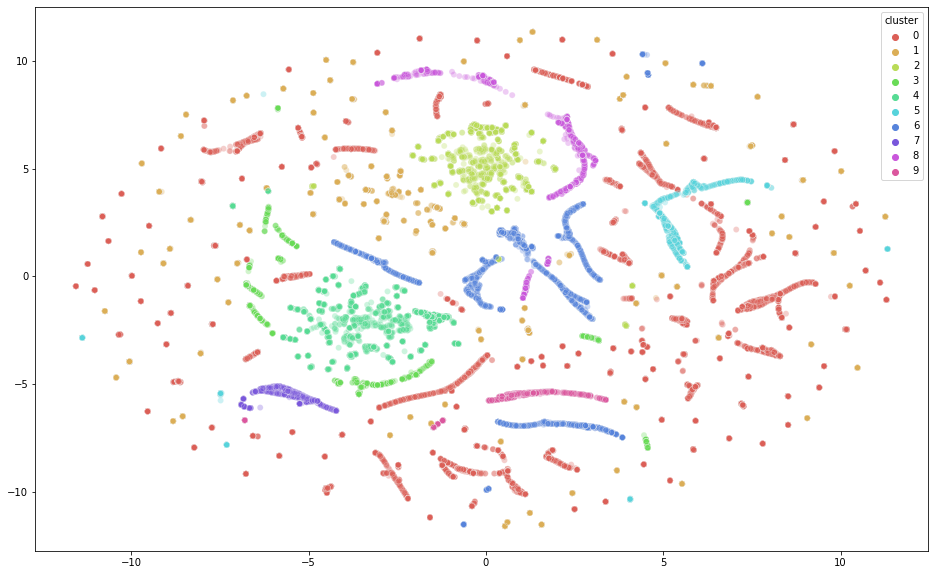

In [7]:
df_10 = kmeans(df_norm, 10, 100000)
t_sne(df_10, 10)

In [11]:
from sklearn.cluster import KMeans
n_clusters = 10
epo = 100000
points = df_norm.values
kmeans = KMeans(n_clusters, max_iter = epo, verbose = 1).fit(points)
#df['cluster'] = kmeans.labels_

Initialization complete
Iteration 0, inertia 120109.4542601131
Iteration 1, inertia 61555.77448321166
Iteration 2, inertia 61541.41859013489
Iteration 3, inertia 61531.17044850532
Iteration 4, inertia 61519.796179120414
Iteration 5, inertia 61491.05753079363
Iteration 6, inertia 61243.62667847658
Iteration 7, inertia 61130.39753018161
Iteration 8, inertia 61130.21485071234
Iteration 9, inertia 61130.17276738844
Iteration 10, inertia 61130.15082444722
Converged at iteration 10: strict convergence.
Initialization complete
Iteration 0, inertia 113274.10404543816
Iteration 1, inertia 59101.75742526977
Iteration 2, inertia 58708.09344776114
Iteration 3, inertia 58570.88109362055
Iteration 4, inertia 58452.474149226844
Iteration 5, inertia 58345.35228311387
Iteration 6, inertia 58329.23364298362
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 120247.8935358981
Iteration 1, inertia 64928.544004110314
Iteration 2, inertia 63928.70647256842
Iteration 3

In [13]:
kmeans

KMeans(max_iter=100000, n_clusters=10, verbose=1)

In [18]:
kmeans.labels_

array([1, 3, 6, ..., 1, 7, 7])

In [15]:
cluster = kmeans.predict(points)

In [16]:
cluster

array([1, 3, 6, ..., 1, 7, 7])

In [20]:
a = kmeans.labels_ - cluster

In [22]:
a.sum()

0

In [23]:
from sklearn.metrics import silhouette_score

In [25]:
score = silhouette_score(points, kmeans.labels_)

In [26]:
score

0.28026593278925765

Initialization complete
Iteration 0, inertia 134615.5805618783
Iteration 1, inertia 68729.28973090785
Iteration 2, inertia 67940.65032575926
Iteration 3, inertia 67812.24992954436
Iteration 4, inertia 67742.9049635563
Iteration 5, inertia 67736.48164441118
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 135303.7414278519
Iteration 1, inertia 68202.23261487782
Iteration 2, inertia 67010.90442264263
Iteration 3, inertia 66203.07675731533
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 138623.17498702815
Iteration 1, inertia 75515.3799591691
Iteration 2, inertia 71221.87429745855
Iteration 3, inertia 70547.60218554523
Iteration 4, inertia 70538.71927286274
Iteration 5, inertia 70532.68046320856
Iteration 6, inertia 70529.76807412553
Iteration 7, inertia 70524.57052732704
Iteration 8, inertia 70515.67237731822
Iteration 9, inertia 70491.56253403486
Iteration 10, inertia 70454.14697647489
Iteration 11, ine

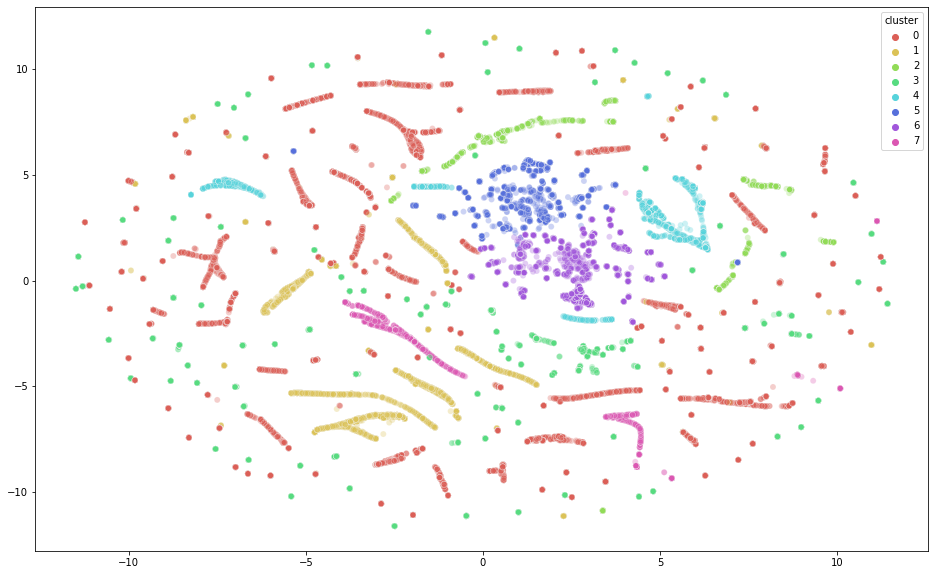

In [28]:
df_8, score = kmeans(df_norm, 8, 100000)
t_sne(df_8, 8)
print(score)

Initialization complete
Iteration 0, inertia 144256.1634025654
Iteration 1, inertia 77099.5121924268
Iteration 2, inertia 76395.50724597498
Iteration 3, inertia 76217.0538731125
Iteration 4, inertia 76207.69683427688
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 147277.1191738663
Iteration 1, inertia 78344.707494055
Iteration 2, inertia 78037.16166595678
Iteration 3, inertia 77898.20373142803
Iteration 4, inertia 77855.35615470984
Iteration 5, inertia 77843.3125158076
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 140203.11841580863
Iteration 1, inertia 77267.15845853227
Iteration 2, inertia 76998.37803665346
Iteration 3, inertia 76743.92948713845
Iteration 4, inertia 76653.24406340157
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 149189.2037572876
Iteration 1, inertia 77841.13705123584
Iteration 2, inertia 75789.14140391411
Iteration 3, inertia 75191.75

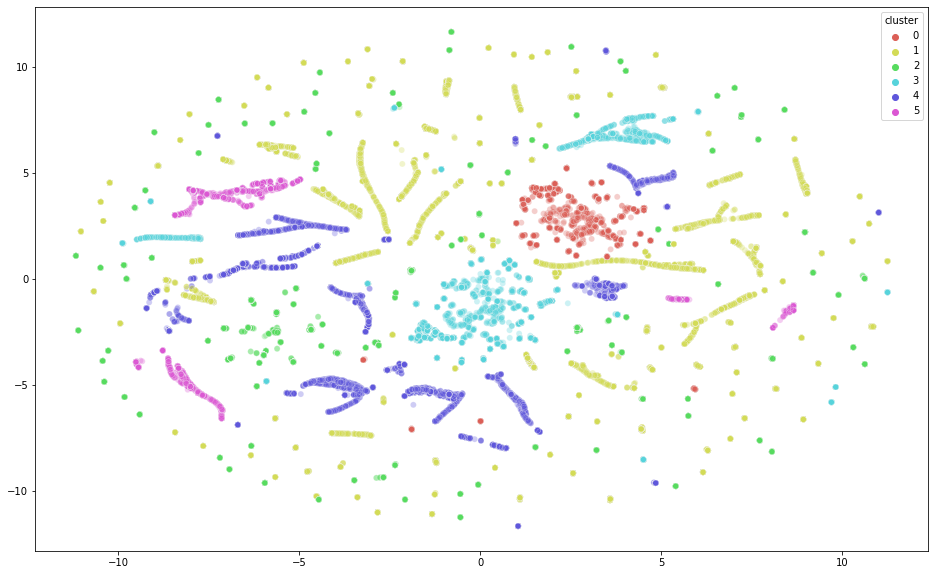

In [29]:
df_6, score = kmeans(df_norm, 6, 100000)
t_sne(df_6, 6)
print(score)

Initialization complete
Iteration 0, inertia 142931.3457468336
Iteration 1, inertia 78102.6504784082
Iteration 2, inertia 78067.23576036807
Iteration 3, inertia 78066.8903981194
Converged at iteration 3: center shift 9.843308276809225e-07 within tolerance 1.6589692791741857e-06.
Initialization complete
Iteration 0, inertia 149403.16259490282
Iteration 1, inertia 78977.3395558689
Iteration 2, inertia 78078.60684580979
Iteration 3, inertia 78067.32647239343
Iteration 4, inertia 78066.8903981194
Converged at iteration 4: center shift 9.843308276809302e-07 within tolerance 1.6589692791741857e-06.
Initialization complete
Iteration 0, inertia 149666.64500379658
Iteration 1, inertia 85065.02195024877
Iteration 2, inertia 84811.75644458481
Iteration 3, inertia 84685.19730654123
Iteration 4, inertia 84644.08509059492
Iteration 5, inertia 84637.9068669187
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 149107.4988145139
Iteration 1, inertia 78805.691922

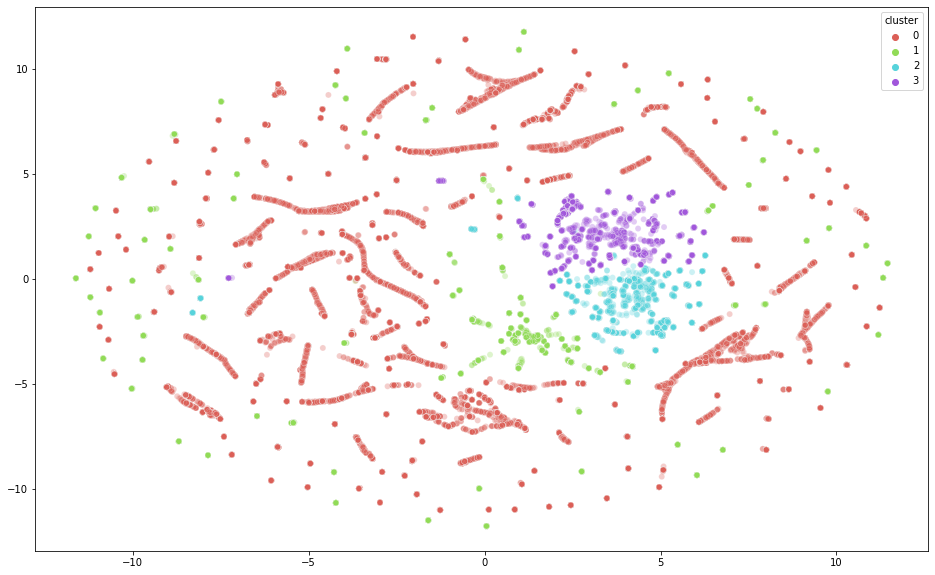

In [31]:
df_4, score = kmeans(df_norm, 4, 100000)
t_sne(df_4, 4)
print(score)

In [32]:
df_2, score = kmeans(df_norm, 2, 100000)
t_sne(df_2, 2)
print(score)

Initialization complete
Iteration 0, inertia 176321.67434658995
Iteration 1, inertia 98455.73862830659
Iteration 2, inertia 98450.98022078347
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 169376.97743413338
Iteration 1, inertia 98450.98022078347
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 173978.44829144172
Iteration 1, inertia 98450.98022078347
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 176967.10437861903
Iteration 1, inertia 98752.83361408212
Iteration 2, inertia 98450.98022078347
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 243316.00654629566
Iteration 1, inertia 129450.06384937416
Iteration 2, inertia 100871.79912707984
Iteration 3, inertia 100659.09158772776
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 170668.21596254932
Iteration 1, inertia 98450.98022

KeyboardInterrupt: 

In [ ]:
df_10, score = kmeans(df_norm, 10, 1000)
t_sne(df_10, 10)
print(score)

In [ ]:
df_9, score = kmeans(df_norm, 9, 100000)
t_sne(df_9, 9)
print(score)

In [ ]:
df_7, score = kmeans(df_norm, 7, 100000)
t_sne(df_7, 7)
print(score)